In [202]:
import urllib.request
import urllib,os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from netCDF4 import Dataset
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

import numlabs.lab5.lab5_funs
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np

download=False
the_file='case_60_10.nc'
the_url="http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/{}".format(the_file)
if download:
    out=urllib.request.urlretrieve(the_url,the_file)
    print(out)
print("download {}: size is {:8.4g} Mbytes".format(the_file,os.path.getsize(the_file)*1.e-6))

download case_60_10.nc: size is    499.3 Mbytes


In [203]:
!ncdump -h case_60_10.nc

netcdf case_60_10 {
dimensions:
	time = 48 ;
	x = 25 ;
	y = 20 ;
	z = 130 ;
variables:
	float time(time) ;
		string time:units = "minutes" ;
	float x(x) ;
		string x:units = "meters" ;
	float y(y) ;
		string y:units = "meters" ;
	float z(z) ;
		string z:units = "meters" ;
	float press(z) ;
		string press:units = "Pa" ;

// global attributes:
		:heat_flux_W_m2 = 100L ;
		:gamma_K_km = 10L ;

group: c1 {
  variables:
  	float TABS(time, z, y, x) ;
  		string TABS:units = "K" ;
  	float W(time, z, y, x) ;
  		string W:units = "m/s" ;
  	float U(time, z, y, x) ;
  		string U:units = "m/s" ;
  	float V(time, z, y, x) ;
  		string V:units = "m/s" ;
  } // group c1

group: c2 {
  variables:
  	float TABS(time, z, y, x) ;
  		string TABS:units = "K" ;
  	float W(time, z, y, x) ;
  		string W:units = "m/s" ;
  	float U(time, z, y, x) ;
  		string U:units = "m/s" ;
  	float V(time, z, y, x) ;
  		string V:units = "m/s" ;
  } // group c2

group: c3 {
  variables:
  	float TABS(time, z, y, x) ;
  

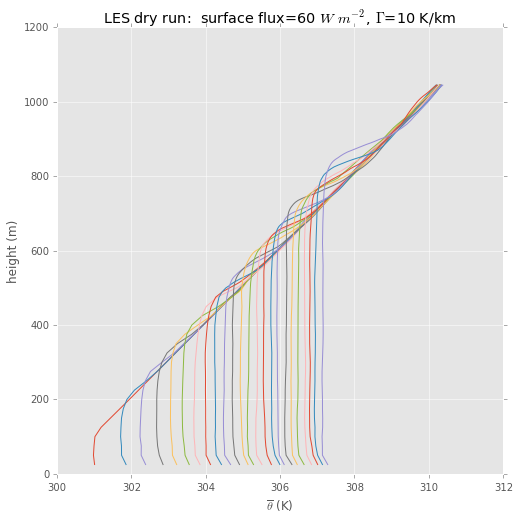

In [204]:
import matplotlib.pyplot as plt

%matplotlib inline

def make_theta(temp,press):
    """
      temp in K
      press in Pa
      returns theta in K
    """
    p0=1.e5
    Rd=287.
    cpd=1004.
    theta=temp*(p0/press)**(Rd/cpd)
    return theta

case_name='case_60_10.nc'
ensemble='c1'
with Dataset(case_name,'r') as ncin:
    group = ncin.groups['c1']
    temp=group.variables['TABS'][...]
    press=ncin.variables['press'][...]
    uvel =group.variables['U'][...]
    vvel =group.variables['V'][...]
    wvel =group.variables['W'][...]
    z = ncin.variables['z'][...]
    y = ncin.variables['y'][...]
    x = ncin.variables['x'][...]
tempprof=temp.mean(axis=3).mean(axis=2)

plt.close('all')
plt.style.use('ggplot')
fig,ax=plt.subplots(1,1,figsize=(8,8))
for i in np.arange(0,temp.shape[0],2):
    theta = make_theta(tempprof[i,:],press)
    ax.plot(theta,z)
ax.set(xlabel=r'$\overline{\theta}$ (K)',ylabel='height (m)',
       title='LES dry run:  surface flux=60 $W\,m^{-2}$, $\Gamma$=10 K/km')
#np.arange(0,temp.shape[0],2)
#tempprof[1,1]
#make_theta(tempprof[1,:],press)
#temp.mean(axis=0).mean(axis=1).mean(axis=1)

In [214]:
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np


class IntegPM(Integrator):

    def set_yinit(self,uvel,vvel,wvel,newx):
        #
        # read in 'mean wind speed - not doing this yet'
        #
        self.config["initvars"]["initialx"]=newx
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'initial locations'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.initialx, self.initvars.initialy, self.initvars.initialz])
        self.nvars = len(self.yinit)
        self.uvel = uvel
        self.vvel = vvel
        self.wvel = wvel
        return None

    def __init__(self, coeff_file_name,uvel,vvel,wvel,newx):
        super().__init__(coeff_file_name)
        self.set_yinit(uvel,vvel,wvel,newx)

    def getvel(self,ti,zz,yy,xx,vels):
        #produces an averaged velocity for values between 
        #data points 
    
        # Args:
        #   t- time variable
        #   x,y,z - decimal spacial coordinates 
        #   vel - the velocity field, one of:
        #   uvel, vvel, wvel
        # Returns:
        #   the new velicities in the u,v,w.
    

        # sort out the x variables
        xtop  = np.ceil(xx)
        xbot  = np.floor(xx)
        txdif = xx - xbot
    
        # sort out the y variables
    
        ytop  = np.ceil(yy)
        ybot  = np.floor(yy)
        tydif = yy - ybot
    
        # sort out the z variables
        ztop  = np.ceil(zz)
        zbot  = np.floor(zz)
        tzdif = zz - zbot
        
        ti = 0
    
        # calculate average velocity at any given piont
        
  
        uA = (vels[ti,ztop,ytop,xtop]*(1.-tzdif)*(1.-tydif)*(1.-txdif))
        uB = (vels[ti,ztop,ybot,xbot]*(1.-tzdif)*(1.-tydif)*txdif)
        uC = (vels[ti,zbot,ytop,xtop]*(1.-tzdif)*tydif     *txdif)
        uD = (vels[ti,zbot,ytop,xbot]*(1.-tzdif)*tydif     *(1.-txdif))
        uE = (vels[ti,ztop,ybot,xbot]*(tzdif)   *(1.-tydif)*(1.-txdif))
        uF = (vels[ti,ztop,ybot,xtop]*(tzdif)   *(1.-tydif)*(txdif) )
        uG = (vels[ti,ztop,ytop,xtop]*(tzdif)   *(tydif)   *(txdif))
        uH = (vels[ti,ztop,ytop,xbot]*(tzdif)   *(tydif)   *(1.-txdif))
    
            # add all pionts together and return value
        nuVel= (uA + uB + uC + uD + uE + uF + uG + uH)
        return(nuVel)
    


    def derivs5(self, y, t):
        """y[0]= starting x position
           y[1]= starting y position
           y[2]= starting z position
        """
        #nuv, nvv, nwv = self.getvel(t,y[2],y[1],y[0])
        #tvar = self.timevars
        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty_like(y)
        #f = np.array([nuv,nvv,nwv])
        #f = self.getvel(t,y[2],y[1],y[0])
        f[0] = self.getvel(t,y[2],y[1],y[0],uvel)
        f[1] = self.getvel(t,y[2],y[1],y[0],vvel)
        f[2] = self.getvel(t,y[2],y[1],y[0],wvel)
        return (f)

In [215]:
diff = 0.5
newx = np.arange(1,5+diff,diff)
dm = np.size(newx)

for i in range(0, len(newx)):
    theSolver = IntegPM('project1.yaml',uvel,vvel,wvel,newx[i])
    timeVals, yVals, errorList = theSolver.timeloop5fixed()
    #tempsg[l] = theSolver.find_temp(ylast[l])
    if i==0:
        allx = np.empty([dm,yVals.shape[0],3])
    allx[i,:,:] = yVals
    #print(yVals.shape)


#theSolver=IntegPM('project1.yaml',uvel,vvel,wvel,newx)
#timeVals,yVals,errorList=theSolver.timeloop5fixed()



IndexError: index 25 is out of bounds for axis 3 with size 25

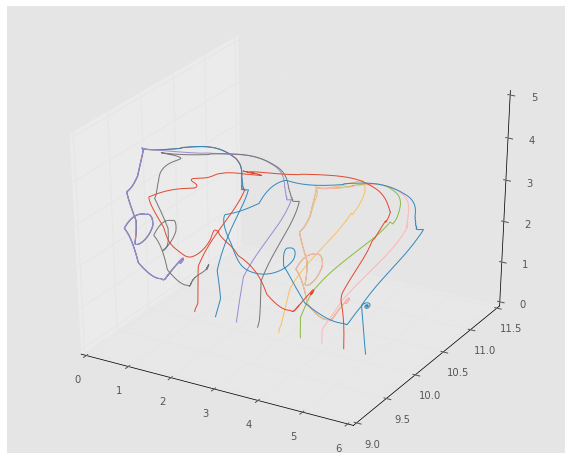

In [213]:


fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

for i in range(0,len(newx)):
    xp = allx[i,:,0]
    yp = yVals[:,1]
    zp = yVals[:,2]
    ax.plot(xp, yp, zp)

#plt.close('all')
#plt.style.use('ggplot')
#fig,ax=plt.subplots(1,1,figsize=(8,8))
#for i in np.arange(0,temp.shape[0],2):
    #theta = make_theta(tempprof[i,:],press)
    #ax.plot(theta,z)
#ax.set(xlabel=r'$\overline{\theta}$ (K)',ylabel='height (m)',
       #title='LES dry run:  surface flux=60 $W\,m^{-2}$, $\Gamma$=10 K/km')

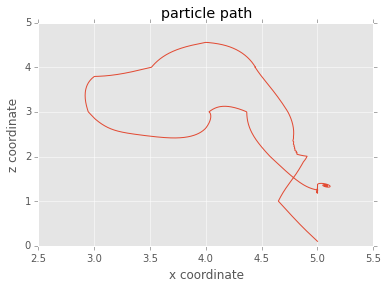

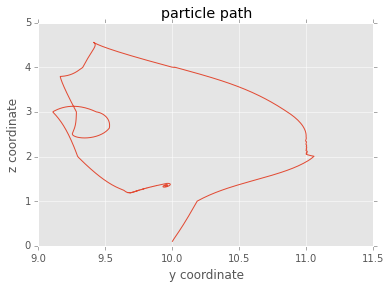

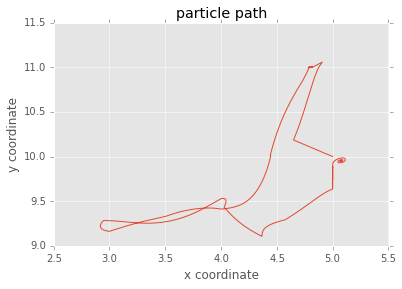

In [208]:


plt.close('all')
thefig, theAx = plt.subplots(1,1)
theLines = theAx.plot(yVals[:,0], yVals[:,2])
theAx.set_title('particle path')
theAx.set_xlabel('x coordinate')
theAx.set_ylabel('z coordinate')
#theAx.legend(theLines, ('white daisies', 'black daisies'), loc='best')

thefig, theAx = plt.subplots(1,1)
theLines = theAx.plot(yVals[:,1], yVals[:,2])
theAx.set_title('particle path')
theAx.set_xlabel('y coordinate')
theAx.set_ylabel('z coordinate')

thefig, theAx = plt.subplots(1,1)
theLines = theAx.plot(yVals[:,0], yVals[:,1])
theAx.set_title('particle path')
theAx.set_xlabel('x coordinate')
theAx.set_ylabel('y coordinate')
#out=theAx.legend(theLines, ('white errors', 'black errors'), loc='best')

In [209]:
def getvelp(ti,zz,yy,xx):
        #produces an averaged velocity for values between 
        #data points 
    
        # Args:
        #   t- time variable
        #   x,y,z - decimal spacial coordinates 
        #   vel - the velocity field, one of:
        #   uvel, vvel, wvel
        # Returns:
        #   the new velicities in the u,v,w.
    

        # sort out the x variables
        xtop  = np.ceil(xx)
        xbot  = np.floor(xx)
        txdif = xx - xbot
    
        # sort out the y variables
    
        ytop  = np.ceil(yy)
        ybot  = np.floor(yy)
        tydif = yy - ybot
    
        # sort out the z variables
        ztop  = np.ceil(zz)
        zbot  = np.floor(zz)
        tzdif = zz - zbot
        
        ti = 0
    
        # calculate average velocity at any given piont
            
        uA = (vels[i][ti,ztop,ytop,xtop]*(1.-tzdif)*(1.-tydif)*(1.-txdif))
        uB = (vels[i][ti,ztop,ybot,xbot]*(1.-tzdif)*(1.-tydif)*txdif)
        uC = (vels[i][ti,zbot,ytop,xtop]*(1.-tzdif)*tydif     *txdif)
        uD = (vels[i][ti,zbot,ytop,xbot]*(1.-tzdif)*tydif     *(1.-txdif))
        uE = (vels[i][ti,ztop,ybot,xbot]*(tzdif)   *(1.-tydif)*(1.-txdif))
        uF = (vels[i][ti,ztop,ybot,xtop]*(tzdif)   *(1.-tydif)*(txdif) )
        uG = (vels[i][ti,ztop,ytop,xtop]*(tzdif)   *(tydif)   *(txdif))
        uH = (vels[i][ti,ztop,ytop,xbot]*(tzdif)   *(tydif)   *(1.-txdif))
    
            # add all pionts together and return value
        nuVel = (uA + uB + uC + uD + uE + uF + uG + uH)
        return(nuVel)


In [210]:
 vels = np.array([uvel,vvel,wvel])

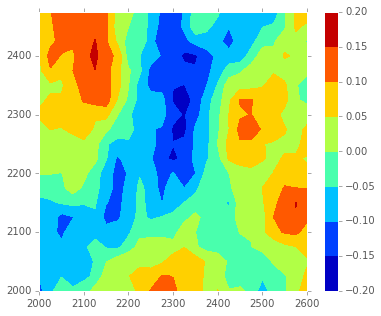

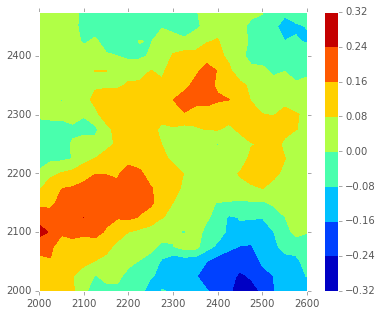

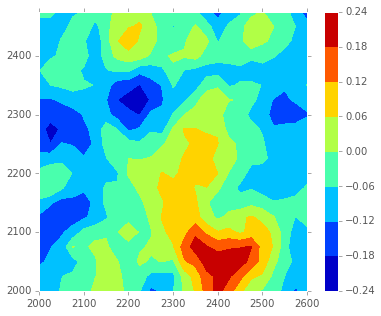

In [211]:
fig,ax = plt.subplots(1,1,figsize=(6,5))
a = ax.contourf(x,y,uvel[20,120,:,:])
#b = ax[1].contourf(x,y,vvel[20,120,:,:])
#c = ax[2].contourf(x,y,wvel[20,120,:,:])

cbar = plt.colorbar(a)

fig,ax = plt.subplots(1,1,figsize=(6,5))
#a = ax.contourf(x,y,uvel[20,120,:,:])
b = ax.contourf(x,y,vvel[20,120,:,:])
#c = ax[2].contourf(x,y,wvel[20,120,:,:])
cbar = plt.colorbar(b)

fig,ax = plt.subplots(1,1,figsize=(6,5))
#a = ax.contourf(x,y,uvel[20,120,:,:])
#b = ax[1].contourf(x,y,vvel[20,120,:,:])
c = ax.contourf(x,y,wvel[20,120,:,:])

cbar = plt.colorbar(c)


In [212]:
vels = np.array([uvel,vvel,wvel])
nuVel = np.empty_like(np.array([1,1,1]))
ti = 0
for i in range(0,len(vels)):
            
    uA = (vels[i][ti,ztop,ytop,xtop]*(1.-tzdif)*(1.-tydif)*(1.-txdif))
    uB = (vels[i][ti,ztop,ybot,xbot]*(1.-tzdif)*(1.-tydif)*txdif)
    uC = (vels[i][ti,zbot,ytop,xtop]*(1.-tzdif)*tydif     *txdif)
    uD = (vels[i][ti,zbot,ytop,xbot]*(1.-tzdif)*tydif     *(1.-txdif))
    uE = (vels[i][ti,ztop,ybot,xbot]*(tzdif)   *(1.-tydif)*(1.-txdif))
    uF = (vels[i][ti,ztop,ybot,xtop]*(tzdif)   *(1.-tydif)*(txdif) )
    uG = (vels[i][ti,ztop,ytop,xtop]*(tzdif)   *(tydif)   *(txdif))
    uH = (vels[i][ti,ztop,ytop,xbot]*(tzdif)   *(tydif)   *(1.-txdif))
    
            # add all pionts together and return value
    nuVel[i] = (uA + uB + uC + uD + uE + uF + uG + uH)

NameError: name 'ztop' is not defined